# Testing `Fortran` implementation

In [1]:
import sys
sys.path.insert(1, '../')

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigsh

import hamiltonians as ham
import physical_constants as const
import bethe_salpeter_equation as bse


from potential import rytova_keldysh

## Comparing with the pure Python (Numba)

In [3]:
for method in dir(rytova_keldysh):
    if method[0] != '_': print(method)

build_potential_matrix
epsilon_0
pi
potential_average
vkk_const


In [13]:
a = rytova_keldysh.pi # IT WILL BE ACCESSIBLE ONLY WHEN THE WHOLE MODULE IS "PUBLIC"

In [20]:
a[()] # THIS IS THE WAY TO ACCESS 0-DIMENSIONAL ARRAY VALUES

3.1415927

In [21]:
n_mesh = 6
n_sub  = 6
kmax   = 5
kx     = np.linspace(-kmax,kmax,n_mesh)

In [22]:
dk  = kx[1] - kx[0]
dk2 = dk**2
eps = 1.
r_0 = 5.
V_orig = ham.Rytova_Keldysh(dk2, r_0, eps) 

In [23]:
bse.potential_average(V_orig, np.array([0.,0.]), n_sub, 200)

-316.69588140364453

In [24]:
Vkk_const = -(1e6/(2*const.EPSILON_0)) * dk2/(2*np.pi)**2

In [25]:
v_fortran = rytova_keldysh.potential_average(0.,0., dk,n_sub, eps, r_0)

In [26]:
v_fortran * Vkk_const

-316.69583226495763

In [27]:
print(rytova_keldysh.potential_average.__doc__)

mean_pot = potential_average(k_x,k_y,delta_k,n_sub,eps,r_0)

Wrapper for ``potential_average``.

Parameters
----------
k_x : input float
k_y : input float
delta_k : input float
n_sub : input int
eps : input float
r_0 : input float

Returns
-------
mean_pot : float



In [10]:
def pot_ave(kx,ky,dk,nsub,eps,r_0):
    dk_sub = dk/(nsub-1)
    kx_ini = kx-dk/2
    ky_ini = ky-dk/2
    Ntotal = nsub**2
    v_sum = 0
    
    for i in range(nsub):
#         ky_sweep = ky_ini
        kx_sweep = kx_ini + i*dk_sub
#         print('kx_sweep = ', kx_sweep)
#         print('{} x {} = {}'.format(i,dk_sub,i*dk_sub))
        print('')
        for j in range(nsub):
            ky_sweep = ky_ini + j*dk_sub
            print('ky_sweep = ', ky_sweep)
            knorm = np.sqrt(kx_sweep**2+ky_sweep**2)
            if (knorm != 0):
                v_sum = v_sum + 1/(eps*knorm + r_0*knorm**2)
            else:
                Ntotal = Ntotal-1
    
    return v_sum/Ntotal

In [11]:
-Vkk_const*pot_ave(0.,0., dk,n_sub, eps, r_0)


ky_sweep =  -1.0
ky_sweep =  -0.6
ky_sweep =  -0.19999999999999996
ky_sweep =  0.20000000000000018
ky_sweep =  0.6000000000000001
ky_sweep =  1.0

ky_sweep =  -1.0
ky_sweep =  -0.6
ky_sweep =  -0.19999999999999996
ky_sweep =  0.20000000000000018
ky_sweep =  0.6000000000000001
ky_sweep =  1.0

ky_sweep =  -1.0
ky_sweep =  -0.6
ky_sweep =  -0.19999999999999996
ky_sweep =  0.20000000000000018
ky_sweep =  0.6000000000000001
ky_sweep =  1.0

ky_sweep =  -1.0
ky_sweep =  -0.6
ky_sweep =  -0.19999999999999996
ky_sweep =  0.20000000000000018
ky_sweep =  0.6000000000000001
ky_sweep =  1.0

ky_sweep =  -1.0
ky_sweep =  -0.6
ky_sweep =  -0.19999999999999996
ky_sweep =  0.20000000000000018
ky_sweep =  0.6000000000000001
ky_sweep =  1.0

ky_sweep =  -1.0
ky_sweep =  -0.6
ky_sweep =  -0.19999999999999996
ky_sweep =  0.20000000000000018
ky_sweep =  0.6000000000000001
ky_sweep =  1.0


316.69588140364436

In [12]:
kmin = -kmax
dk_test = (kmax-kmin)/(n_mesh-1)

In [13]:
dk_test

2.0

In [14]:
dk

2.0

In [15]:
np.pi

3.141592653589793

## Value order in 2D arrays

In [16]:
Kx,Ky = np.meshgrid(kx,kx)

In [17]:
Kx

array([[-5., -3., -1.,  1.,  3.,  5.],
       [-5., -3., -1.,  1.,  3.,  5.],
       [-5., -3., -1.,  1.,  3.,  5.],
       [-5., -3., -1.,  1.,  3.,  5.],
       [-5., -3., -1.,  1.,  3.,  5.],
       [-5., -3., -1.,  1.,  3.,  5.]])

In [18]:
Ky

array([[-5., -5., -5., -5., -5., -5.],
       [-3., -3., -3., -3., -3., -3.],
       [-1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 3.,  3.,  3.,  3.,  3.,  3.],
       [ 5.,  5.,  5.,  5.,  5.,  5.]])

In [19]:
kx_flat = Kx.flatten(order='C')
ky_flat = Ky.flatten(order='C')

## Test build potential Fortran (f2py)

In [20]:
print(rytova_keldysh.build_potential_matrix.__doc__)

v = build_potential_matrix(kx_flat,ky_flat,n_sub,eps,r_0,[n_total])

Wrapper for ``build_potential_matrix``.

Parameters
----------
kx_flat : input rank-1 array('f') with bounds (n_total)
ky_flat : input rank-1 array('f') with bounds (n_total)
n_sub : input int
eps : input float
r_0 : input float

Other Parameters
----------------
n_total : input int, optional
    Default: len(kx_flat)

Returns
-------
v : rank-2 array('f') with bounds (n_total,n_total)



In [27]:
V = rytova_keldysh.build_potential_matrix(kx_flat, ky_flat, n_sub,eps, r_0)

In [28]:
V.shape

(36, 36)

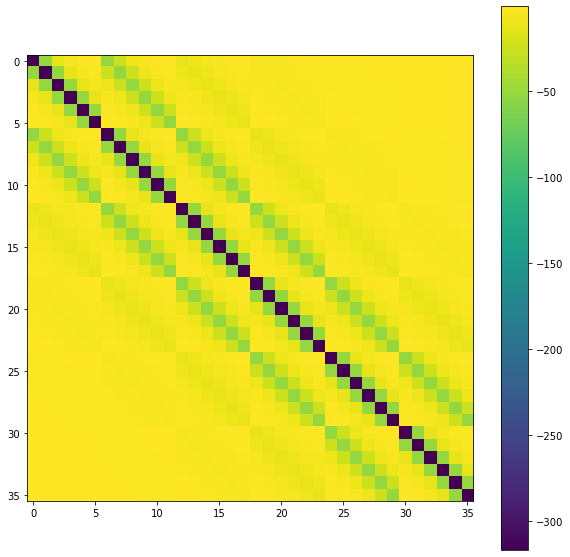

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
map_color = ax.imshow(V)
fig.colorbar(map_color,ax=ax)
plt.show()

## Convert the matrix into sparse

In [36]:
sparseV = sparse.csr_matrix(V)

In [40]:
Values, Vectors = eigsh(V,k=4,which='SA')

In [24]:
VMatrix_orig = bse.potential_matrix(V_orig, Kx, Ky, n_sub, submesh_radius=200)

In [25]:
VMatrix_orig.shape

(36, 36)

In [26]:
np.max(VMatrix_orig-V)

-833.3929857781503